In [24]:
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPool2D
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [25]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    tr_files, tr_classes = define_paths(data_dir+'/train')
    ts_files, ts_classes = define_paths(data_dir+'/test')
    dummy_df = define_df(tr_files, tr_classes)
    ts_df = define_df(ts_files, ts_classes)

    # valid and test dataframe
    strat = dummy_df['labels']
    tr_df, valid_df = train_test_split(dummy_df,  train_size= 0.75, shuffle= True, random_state= 123, stratify= strat)

    return tr_df, valid_df, ts_df

In [26]:
# import system libs
import os
import time
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as pltAC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [3]:
from sklearn.model_selection import train_test_split

In [19]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    tr_files, tr_classes = define_paths(data_dir+'/train')
    ts_files, ts_classes = define_paths(data_dir+'/test')
    dummy_df = define_df(tr_files, tr_classes)
    ts_df = define_df(ts_files, ts_classes)

    # valid and test dataframe
    strat = dummy_df['labels']
    tr_df, valid_df = train_test_split(dummy_df,  train_size= 0.75, shuffle= True, random_state= 123, stratify= strat)

    return tr_df, valid_df, ts_df

In [20]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [21]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (300, 300)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    # Initialize an empty list to store batch sizes
    valid_batch_sizes = []

    # Iterate through possible factors of ts_length
    for n in range(1, ts_length + 1):
        if ts_length % n == 0 and ts_length / n <= 80:
            valid_batch_sizes.append(ts_length // n)

    # Sort the valid batch sizes in descending order
    valid_batch_sizes.sort(reverse=True)

    # Choose the largest valid batch size
    test_batch_size = valid_batch_sizes[0]
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        img = tf.image.rot90(img, k=np.random.randint(0, 4))
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=0.1)
        img = img + noise
        return img



    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [27]:
data_dir = 'C:/Users/u2285811/OneDrive - University of Huddersfield/project_files/alz_copy'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print(e)

Found 2518 validated image filenames belonging to 4 classes.
Found 840 validated image filenames belonging to 4 classes.
Found 638 validated image filenames belonging to 4 classes.


In [15]:
path='C:/Users/u2285811/OneDrive - University of Huddersfield/project_files/alz_copy'
os.listdir(path)

['test', 'train']

In [18]:
data_dir = 'project_files/alz_copy/train'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print('Invalid Input',e)

Invalid Input [WinError 3] The system cannot find the path specified: 'project_files/alz_copy/train/train'


In [28]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np

In [30]:
from keras.models import Model


In [31]:
inception = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in inception.layers:
    layer.trainable = False
x = Flatten()(inception.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

inceptionnet= Model(inputs=inception.input, outputs=out)

#Compiling
inceptionnet.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
#Summary
inceptionnet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94[

                                                                                                  
 conv2d_104 (Conv2D)         (None, 25, 25, 96)           82944     ['activation_103[0][0]']      
                                                                                                  
 conv2d_105 (Conv2D)         (None, 25, 25, 32)           6144      ['average_pooling2d_9[0][0]'] 
                                                                                                  
 batch_normalization_99 (Ba  (None, 25, 25, 64)           192       ['conv2d_99[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_101 (B  (None, 25, 25, 64)           192       ['conv2d_101[0][0]']          
 atchNormalization)                                                                               
          

                                                                                                  
 activation_108 (Activation  (None, 25, 25, 64)           0         ['batch_normalization_108[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_111 (Activation  (None, 25, 25, 96)           0         ['batch_normalization_111[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_112 (Activation  (None, 25, 25, 64)           0         ['batch_normalization_112[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (C

                                                                                                  
 activation_121 (Activation  (None, 25, 25, 64)           0         ['batch_normalization_121[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_122 (Conv2D)         (None, 25, 25, 96)           55296     ['activation_121[0][0]']      
                                                                                                  
 batch_normalization_122 (B  (None, 25, 25, 96)           288       ['conv2d_122[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_122 (Activation  (None, 25, 25, 96)           0         ['batch_normalization_122[0][0
 )        

 average_pooling2d_12 (Aver  (None, 12, 12, 768)          0         ['mixed3[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_124 (Conv2D)         (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_127 (Conv2D)         (None, 12, 12, 192)          172032    ['activation_126[0][0]']      
                                                                                                  
 conv2d_132 (Conv2D)         (None, 12, 12, 192)          172032    ['activation_131[0][0]']      
                                                                                                  
 conv2d_133 (Conv2D)         (None, 12, 12, 192)          147456    ['average_pooling2d_12[0][0]']
          

 )                                                                  ]']                           
                                                                                                  
 activation_141 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_141[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_13 (Aver  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_134 (Conv2D)         (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_13

                                                                                                  
 batch_normalization_151 (B  (None, 12, 12, 160)          480       ['conv2d_151[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_146 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_146[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_151 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_151[0][0
 )                                                                  ]']                           
                                                                                                  
 average_p

                                                                                                  
 conv2d_161 (Conv2D)         (None, 12, 12, 192)          258048    ['activation_160[0][0]']      
                                                                                                  
 batch_normalization_156 (B  (None, 12, 12, 192)          576       ['conv2d_156[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_161 (B  (None, 12, 12, 192)          576       ['conv2d_161[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_156 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_156[0][0
 )        

                                                                                                  
 activation_168 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_168[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_165 (Conv2D)         (None, 5, 5, 320)            552960    ['activation_164[0][0]']      
                                                                                                  
 conv2d_169 (Conv2D)         (None, 5, 5, 192)            331776    ['activation_168[0][0]']      
                                                                                                  
 batch_normalization_165 (B  (None, 5, 5, 320)            960       ['conv2d_165[0][0]']          
 atchNormalization)                                                                               
          

                                                                                                  
 activation_173 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_173[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_176 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_176[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_177 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_177[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_nor

                                                                                                  
 activation_181 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_181[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_182 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_182[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_185 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_185[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

In [32]:
batch_size=60
epoch=10
callback= keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [34]:
batch_size=60
img_size=(224,224)
image_generator = ImageDataGenerator(rescale=1/255., validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)
train_data = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory='C:/Users/u2285811/OneDrive - University of Huddersfield/project_files/alz_copy/train',
                                                 shuffle=True,
                                                 target_size=img_size,
                                                 subset="training",
                                                 class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2)
validation_data= image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory='C:/Users/u2285811/OneDrive - University of Huddersfield/project_files/alz_copy/test',
                                                 shuffle=True,
                                                 target_size=img_size,
                                                 class_mode='categorical')


submission = image_generator.flow_from_directory(
                                                 directory='C:/Users/u2285811/OneDrive - University of Huddersfield/project_files/alz_copy/test',
                                                 shuffle=False,
                                                subset="validation",
                                                 target_size=img_size,
                                                 class_mode=None)

Found 3358 images belonging to 4 classes.
Found 638 images belonging to 4 classes.
Found 127 images belonging to 4 classes.


In [35]:
hist_inception=inceptionnet.fit(train_data, epochs=25, validation_data=validation_data, callbacks=callback)

Epoch 1/25
56/56 [==============================] - 552s 10s/step - loss: 4.6080 - accuracy: 0.5697 - val_loss: 2.1848 - val_accuracy: 0.3966
Epoch 2/25
56/56 [==============================] - 29s 526ms/step - loss: 0.5455 - accuracy: 0.7740 - val_loss: 1.0015 - val_accuracy: 0.5940
Epoch 3/25
56/56 [==============================] - 29s 522ms/step - loss: 0.4206 - accuracy: 0.8341 - val_loss: 1.2823 - val_accuracy: 0.4545
Epoch 4/25
56/56 [==============================] - 29s 525ms/step - loss: 0.3616 - accuracy: 0.8466 - val_loss: 0.9277 - val_accuracy: 0.5972
Epoch 5/25
56/56 [==============================] - 29s 525ms/step - loss: 0.2380 - accuracy: 0.9098 - val_loss: 0.8392 - val_accuracy: 0.6724
Epoch 6/25
56/56 [==============================] - 30s 530ms/step - loss: 0.2431 - accuracy: 0.9050 - val_loss: 1.3280 - val_accuracy: 0.5690
Epoch 7/25
56/56 [==============================] - 29s 526ms/step - loss: 0.1817 - accuracy: 0.9309 - val_loss: 1.2539 - val_accuracy: 0.5674


In [47]:
vgg19 = VGG19(input_shape=(224, 224, 3), weights="imagenet", include_top=False)


for layer in vgg19.layers:
    layer.trainable = False


x = Flatten()(vgg19.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelvgg19 = Model(inputs=vgg19.input, outputs=out)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

#compiling
modelvgg19.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

#Summary
modelvgg19.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [48]:
hist_vgg_19=modelvgg19.fit(train_data, epochs=25, validation_data=validation_data, callbacks=callback)

Epoch 1/25
56/56 [==============================] - 128s 2s/step - loss: 1.3307 - accuracy: 0.5646 - val_loss: 1.1512 - val_accuracy: 0.4906
Epoch 2/25
56/56 [==============================] - 127s 2s/step - loss: 0.6640 - accuracy: 0.7031 - val_loss: 0.9473 - val_accuracy: 0.5423
Epoch 3/25
56/56 [==============================] - 128s 2s/step - loss: 0.5520 - accuracy: 0.7719 - val_loss: 0.8334 - val_accuracy: 0.6160
Epoch 4/25
56/56 [==============================] - 128s 2s/step - loss: 0.4654 - accuracy: 0.8172 - val_loss: 0.8003 - val_accuracy: 0.6411
Epoch 5/25
56/56 [==============================] - 128s 2s/step - loss: 0.4143 - accuracy: 0.8487 - val_loss: 1.0021 - val_accuracy: 0.5298
Epoch 6/25
56/56 [==============================] - 130s 2s/step - loss: 0.4042 - accuracy: 0.8350 - val_loss: 0.7283 - val_accuracy: 0.6944
Epoch 7/25
56/56 [==============================] - 129s 2s/step - loss: 0.3725 - accuracy: 0.8466 - val_loss: 0.7725 - val_accuracy: 0.6270
Epoch 8/25
56

In [38]:
vgg16 = VGG16(input_shape=(224, 224, 3), weights="imagenet", include_top=False)


for layer in vgg16.layers:
    layer.trainable = False


x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelvgg16 = Model(inputs=vgg16.input, outputs=out)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

#compiling
modelvgg16.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

#Summary
modelvgg16.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [39]:
hist_vgg=modelvgg16.fit(train_data, epochs=25, validation_data=validation_data, callbacks=callback)

Epoch 1/25
56/56 [==============================] - 117s 2s/step - loss: 1.2954 - accuracy: 0.5649 - val_loss: 0.9683 - val_accuracy: 0.5455
Epoch 2/25
56/56 [==============================] - 117s 2s/step - loss: 0.6180 - accuracy: 0.7216 - val_loss: 0.9049 - val_accuracy: 0.5533
Epoch 3/25
56/56 [==============================] - 117s 2s/step - loss: 0.5126 - accuracy: 0.7877 - val_loss: 1.0194 - val_accuracy: 0.5831
Epoch 4/25
56/56 [==============================] - 117s 2s/step - loss: 0.4367 - accuracy: 0.8273 - val_loss: 0.9451 - val_accuracy: 0.5549
Epoch 5/25
56/56 [==============================] - 117s 2s/step - loss: 0.3821 - accuracy: 0.8490 - val_loss: 0.8099 - val_accuracy: 0.6646
Epoch 6/25
56/56 [==============================] - 117s 2s/step - loss: 0.3682 - accuracy: 0.8574 - val_loss: 0.6808 - val_accuracy: 0.7038
Epoch 7/25
56/56 [==============================] - 117s 2s/step - loss: 0.2769 - accuracy: 0.9086 - val_loss: 0.8976 - val_accuracy: 0.6270
Epoch 8/25
56

In [40]:
validation_loss, validation_accuracy = modelvgg16.evaluate(validation_data)

print(f"Validation Accuracy: {validation_accuracy}, Validation Loss: {validation_loss}")

11/11 [==============================] - 19s 2s/step - loss: 0.6808 - accuracy: 0.7038
Validation Accuracy: 0.7037617564201355, Validation Loss: 0.680803656578064


In [41]:
validation_loss, validation_accuracy = inceptionnet.evaluate(validation_data)

print(f"Validation Accuracy: {validation_accuracy}, Validation Loss: {validation_loss}")

11/11 [==============================] - 4s 369ms/step - loss: 0.8392 - accuracy: 0.6724
Validation Accuracy: 0.6724137663841248, Validation Loss: 0.8392066359519958


In [49]:
validation_loss, validation_accuracy = modelvgg19.evaluate(validation_data)

print(f"Validation Accuracy: {validation_accuracy}, Validation Loss: {validation_loss}")

11/11 [==============================] - 23s 2s/step - loss: 0.6256 - accuracy: 0.7210
Validation Accuracy: 0.7210031151771545, Validation Loss: 0.6256489753723145


In [50]:
modelvgg19.save('vgg19.h5')

In [42]:
inceptionnet.save('inception.h5')

In [51]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, DepthwiseConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def simplified_efficient_b3(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Stem convolutional block
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Building blocks inspired by EfficientNet
    filters = 32
    block_config = [n block_config:
        num_filters = block['out_filters']
        num_repeats = block['repeats']
        expansion_factor = block['expansion']
        stride = block['stride']

        for _ in range(num_repeats):
            # Depthwise Convolution
            x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            # Pointwise Convolution
            x = Conv2D(num_filters, kernel_size=1, strides=1, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Create the simplified EfficientNet B3-like model
simplified_eff_b3 = simplified_efficient_b3()
simplified_eff_b3.summary()

        {'expansion': 1, 'out_filters': 16, 'repeats': 1, 'stride': 1},
        {'expansion': 6, 'out_filters': 24, 'repeats': 2, 'stride': 2},
        {'expansion': 6, 'out_filters': 40, 'repeats': 2, 'stride': 2},
        {'expansion': 6, 'out_filters': 80, 'repeats': 3, 'stride': 2},
    ]

    for block i

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_188 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_188 (B  (None, 112, 112, 32)      128       
 atchNormalization)                                              
                                                                 
 activation_188 (Activation  (None, 112, 112, 32)      0         
 )                                                               
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      320       
 eConv2D)                                                        
                                                           

 conv2d_195 (Conv2D)         (None, 2, 2, 80)          6480      
                                                                 
 batch_normalization_202 (B  (None, 2, 2, 80)          320       
 atchNormalization)                                              
                                                                 
 activation_202 (Activation  (None, 2, 2, 80)          0         
 )                                                               
                                                                 
 depthwise_conv2d_7 (Depthw  (None, 1, 1, 80)          800       
 iseConv2D)                                                      
                                                                 
 batch_normalization_203 (B  (None, 1, 1, 80)          320       
 atchNormalization)                                              
                                                                 
 activation_203 (Activation  (None, 1, 1, 80)          0         
 )        

In [56]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Create train and validation generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Define paths to your train and validation directories
train_dir = 'C:/Users/u2285811/OneDrive - University of Huddersfield/project_files/alz_copy/train'
validation_dir = 'C:/Users/u2285811/OneDrive - University of Huddersfield/project_files/alz_copy/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Compile the model
simplified_eff_b3.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model using fit_generator
history = simplified_eff_b3.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,  # Adjust this according to your dataset size and batch size
    epochs=35,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    # Adjust this according to your dataset size and batch size
)


Found 3358 images belonging to 4 classes.
Found 638 images belonging to 4 classes.
Epoch 1/35
104/104 [==============================] - 41s 356ms/step - loss: 0.6275 - accuracy: 0.6909 - val_loss: 1.9395 - val_accuracy: 0.4490
Epoch 2/35
104/104 [==============================] - 37s 353ms/step - loss: 0.6281 - accuracy: 0.6843 - val_loss: 1.7461 - val_accuracy: 0.5280
Epoch 3/35
104/104 [==============================] - 37s 355ms/step - loss: 0.6308 - accuracy: 0.6870 - val_loss: 7.1957 - val_accuracy: 0.2697
Epoch 4/35
104/104 [==============================] - 37s 356ms/step - loss: 0.6255 - accuracy: 0.6888 - val_loss: 16.4310 - val_accuracy: 0.3684
Epoch 5/35
104/104 [==============================] - 37s 357ms/step - loss: 0.6210 - accuracy: 0.6963 - val_loss: 23.4522 - val_accuracy: 0.2286
Epoch 6/35
104/104 [==============================] - 37s 352ms/step - loss: 0.6288 - accuracy: 0.6753 - val_loss: 6.3891 - val_accuracy: 0.2500
Epoch 7/35
104/104 [=========================

In [57]:
validation_loss, validation_accuracy = simplified_eff_b3.evaluate(validation_data)

print(f"Validation Accuracy: {validation_accuracy}, Validation Loss: {validation_loss}")


11/11 [==============================] - 1s 115ms/step - loss: 1.2959 - accuracy: 0.5392
Validation Accuracy: 0.5391849279403687, Validation Loss: 1.2958893775939941


In [58]:
simplified_eff_b3.save('my_arch.h5')

In [60]:
import matplotlib.pyplot as plt

In [62]:
preds = simplified_eff_b3.predict_generator(validation_generator)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 3 2 1 2 1 1 1 1 3 1 1 0 1 1 3 3 1 3 1 1 3 0 3 1 0 1 0 1 2 1 1 1 1 1 1 1
 3 2 1 0 0 3 3 0 2 1 1 1 3 0 1 1 3 1 3 0 1 1 0 0 0 1 1 2 1 1 1 0 0 3 1 3 0
 1 0 0 1 0 3 1 0 0 3 0 3 0 1 0 1 0 0 2 2 1 0 1 1 1 3 0 1 2 1 3 1 0 1 3 1 3
 1 3 1 3 1 1 1 3 1 1 3 2 3 0 1 0 3 3 1 1 1 2 0 3 0 2 3 2 0 0 1 1 3 3 1 1 0
 3 3 3 1 0 1 0 1 2 0 1 1 1 1 1 1 3 2 1 3 0 1 0 0 1 1 3 3 1 3 1 0 1 1 0 1 3
 3 2 1 1 1 0 2 0 0 0 3 1 3 3 0 0 2 1 1 3 0 3 1 3 1 1 3 0 1 1 1 3 3 0 3 1 1
 2 2 1 3 2 0 1 1 3 1 3 1 1 1 1 3 2 1 1 1 1 1 2 1 1 1 3 1 1 0 3 1 1 0 1 1 3
 1 0 1 3 1 3 3 1 1 1 3 1 1 1 1 1 1 2 0 1 1 1 2 3 1 3 0 2 0 3 0 0 3 1 3 3 3
 2 2 1 0 1 1 2 0 1 1 1 1 1 1 1 3 1 0 3 1 3 3 3 1 0 0 3 0 3 1 2 1 1 1 0 2 2
 3 2 0 0 1 0 0 1 0 0 1 3 3 1 2 0 1 1 3 3 1 1 0 1 2 2 3 3 2 0 1 0 1 2 3 3 3
 1 0 1 0 3 1 3 0 1 1 1 1 1 1 0 0 1 3 1 1 1 1 2 1 2 1 1 1 0 2 1 3 3 3 1 0 2
 3 1 1 2 0 2 1 3 0 0 2 1 1 1 3 3 1 0 1 3 1 1 0 3 1 1 1 1 0 1 2 3 1 1 1 0 3
 3 1 1 2 1 1 2 1 1 1 1 0 1 1 0 1 3 1 0 1 1 1 2 1 1 0 3 3 1 1 1 1 1 0 1 3 0
 3 1 2 1 2 3 1 2 2 1 1 1 

Confusion Matrix, Without Normalization
[[36 66 13 35]
 [35 89 20 44]
 [28 74 18 30]
 [25 87 13 25]]
                  precision    recall  f1-score   support

    MildDemented       0.29      0.24      0.26       150
ModerateDemented       0.28      0.47      0.35       188
     NonDemented       0.28      0.12      0.17       150
VeryMildDemented       0.19      0.17      0.18       150

        accuracy                           0.26       638
       macro avg       0.26      0.25      0.24       638
    weighted avg       0.26      0.26      0.25       638



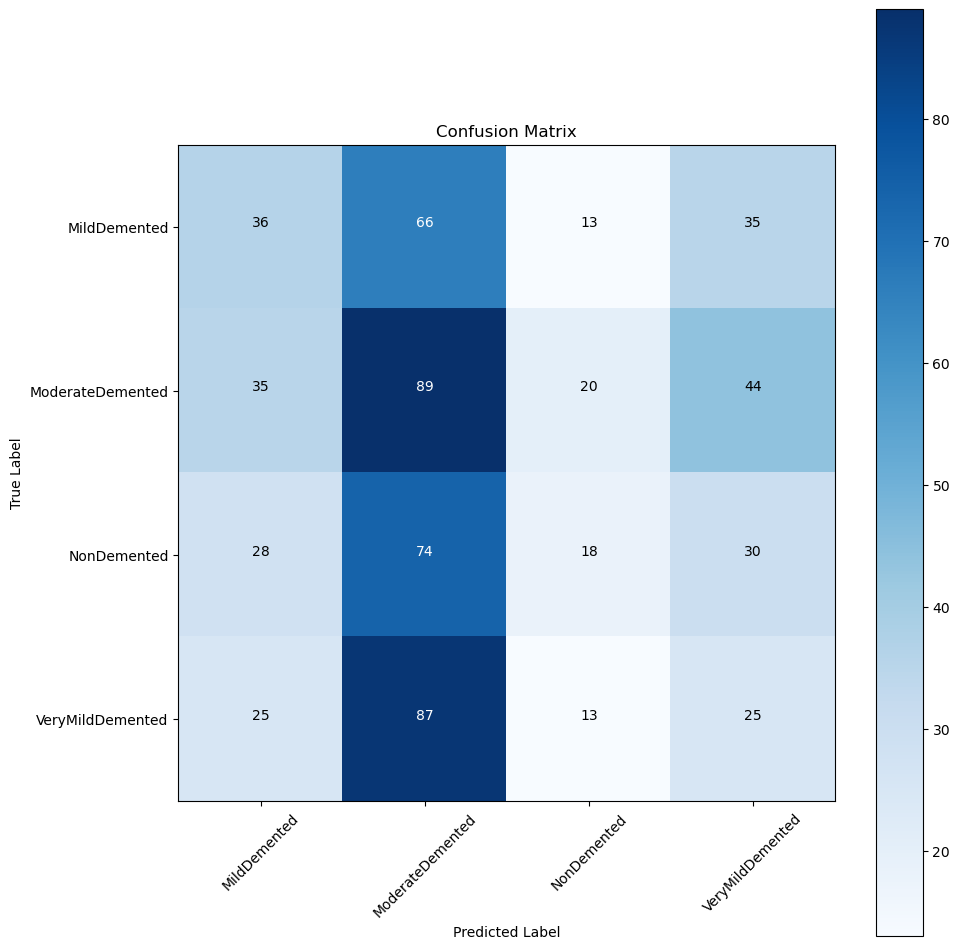

In [63]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [61]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    '''
    This function plot confusion matrix method from sklearn package.
    '''

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')

    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inceptio  t  image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np

# Load InceptionV3 model pre-trained on ImageNet data
model = InceptionV3(weights='imagenet')

# Load and preprocess an image for prediction
img_path = 'path_to_your_image.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make predictions
predictions = model.predict(x)
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Print top 3 predicted classes
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")
